In [0]:
# simple generative adversarial network
# this version uses simple images, the MNIST dataset

In [2]:
# mount drive to access csv files

from google.colab import drive
drive.mount('./mnist_data')

Drive already mounted at ./mnist_data; to attempt to forcibly remount, call drive.mount("./mnist_data", force_remount=True).


In [0]:
# conventional PyTorch imports
import torch
import torch.nn as nn
#import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [4]:
# GPU

#torch.cuda.is_available()
#torch.cuda.get_device_name(0)

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla T4


device(type='cuda')

In [0]:
import random
import pandas

In [0]:
import numpy
import matplotlib.pyplot as plt

In [7]:
# function to generate uniform random data
# size parameter is length of tensor

def generate_random(size):
    #return torch.rand(size)
    return torch.randn(size)

generate_random(5)

tensor([ 1.2839,  0.2094, -0.2427,  0.7949, -0.0543])

In [0]:
# dataset class

class MnistDataset(torch.utils.data.Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        image_target = torch.zeros((10))
        image_target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.cuda.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, image_target
    
    def plot_image(self, index):
        arr = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(arr, interpolation='none', cmap='Blues')
        pass
    
    pass


In [0]:
# subclass PyTorch dataset class, loads actual data, parses it into targets and pizel data
mnist_dataset = MnistDataset('mnist_data/My Drive/Colab Notebooks/gan/mnist_data/mnist_test.csv')

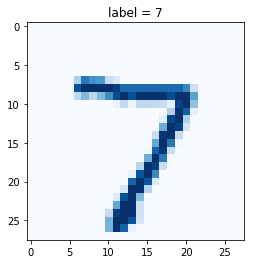

In [10]:
mnist_dataset.plot_image(0)

In [0]:
# from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [0]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # from 1 channel to many separate convolutions
            nn.Conv2d(1, 10, kernel_size=5),
            #nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(10),
            nn.LeakyReLU(0.2),
        
            # 10 channels to 10
            nn.Conv2d(10, 10, kernel_size=3),
            #nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(10),
            nn.LeakyReLU(0.2),
            
            View((1,4840)),
            nn.Linear(4840, 1),
            #View((1,250)),
            #nn.Linear(250, 1),
            nn.Sigmoid()
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using Adam for better gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.00001)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate error
        loss = self.error_function(outputs, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass
        

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [13]:
%%time
# create Discriminator and test it

D = Discriminator()
D.to(device)

# train Discriminator

epochs = 1

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    
    for label, image_data_tensor, target_tensor in mnist_dataset:
        
        # train discriminator on real data
        D.train(image_data_tensor.view(1, 1, 28, 28), torch.cuda.FloatTensor([1.0]).view(1,1))
        
        # train discriminator on false (random) data
        D.train(generate_random(784).view(1, 1, 28, 28), torch.cuda.FloatTensor([0.0]).view(1,1))
    
        pass
    
    pass


training epoch 1 of 1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
CPU times: user 50.6 s, sys: 1.87 s, total: 52.5 s
Wall time: 52.8 s


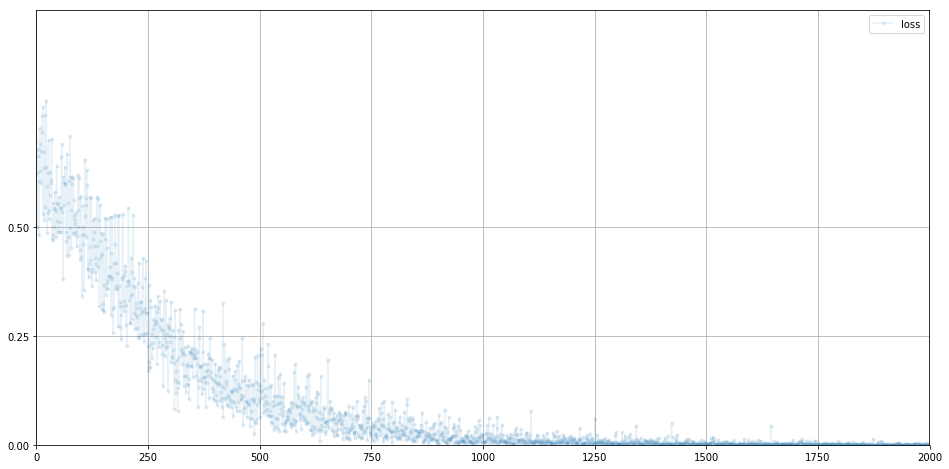

In [14]:
# plot discriminator error

D.plot_progress()

In [15]:
# manually check D can indeed discriminate between real and fake data

print(D.forward(generate_random(784).view(1, 1, 28, 28)))
print(D.forward(generate_random(784).view(1, 1, 28, 28)))
print(D.forward(generate_random(784).view(1, 1, 28, 28)))
print(D.forward(generate_random(784).view(1, 1, 28, 28)))

print(D.forward(mnist_dataset[random.randint(0,10000)][1].view(1, 1, 28, 28)))
print(D.forward(mnist_dataset[random.randint(0,10000)][1].view(1, 1, 28, 28)))
print(D.forward(mnist_dataset[random.randint(0,10000)][1].view(1, 1, 28, 28)))
print(D.forward(mnist_dataset[random.randint(0,10000)][1].view(1, 1, 28, 28)))


tensor([[0.0009]], grad_fn=<SigmoidBackward>)
tensor([[4.8545e-05]], grad_fn=<SigmoidBackward>)
tensor([[0.0011]], grad_fn=<SigmoidBackward>)
tensor([[0.0007]], grad_fn=<SigmoidBackward>)
tensor([[0.9998]], grad_fn=<SigmoidBackward>)
tensor([[0.9999]], grad_fn=<SigmoidBackward>)
tensor([[0.9999]], grad_fn=<SigmoidBackward>)
tensor([[1.0000]], grad_fn=<SigmoidBackward>)


In [0]:
# deconvolution channels
dc1 = 20
dc2 = 2

# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.ConvTranspose2d(1, dc1, kernel_size=3, stride=2),
            nn.BatchNorm2d(dc1),
            nn.LeakyReLU(0.2),
        
            nn.ConvTranspose2d(dc1, dc2, kernel_size=3, stride=2),
            nn.BatchNorm2d(dc2),
            nn.LeakyReLU(0.2),
            
            View((1,43*43*dc2)),
            
            nn.Linear(43*43*dc2,28*28),
            nn.Sigmoid(),
            
            View((1,1,28,28))
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using Adam for better gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.00001)
        
        # counter and accumulator for progress
        self.counter = 0;
        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.error_function(d_output, targets)

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_images(self):
        plt.figure(figsize = (16,8))
        plt.imshow(G.forward(generate_random(100).view(1,1,10,10)).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
        pass
    
    pass

torch.Size([1, 1, 28, 28])


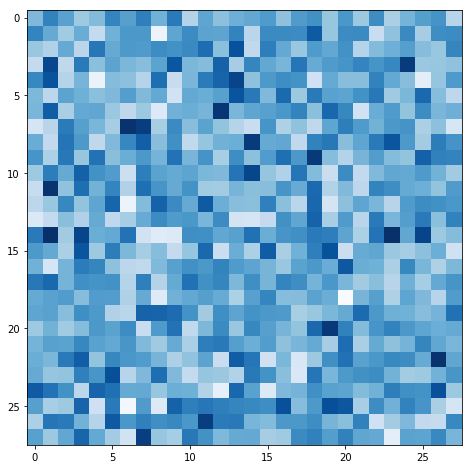

In [76]:
# scratch

G = Generator()

print(G(generate_random(100).view(1,1, 10, 10)).shape)

plt.figure(figsize = (16,8))
plt.imshow(G.forward(generate_random(100).view(1,1,10,10)).view(28,28).detach().cpu().numpy(), 
           interpolation='none',
           cmap='Blues')

In [77]:
# create Discriminator and Generator

D = Discriminator()
D.to(device)

G = Generator()
G.to(device)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(1, 20, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(20, 2, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): View()
    (7): Linear(in_features=3698, out_features=784, bias=True)
    (8): Sigmoid()
    (9): View()
  )
  (error_function): BCELoss()
)

In [95]:
%%time
# train Discriminator and Generator

epochs = 1

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    
    for label, image_data_tensor, target_tensor in mnist_dataset:
        
        # train discriminator on real data
        D.train(image_data_tensor.view(1, 1, 28, 28), torch.cuda.FloatTensor([0.9]).view(1,1))
        
        # train discriminator on false
        # use detach() so only D is updated, not G
        D.train(G.forward(generate_random(100).view(1, 1, 10, 10)).detach(), torch.cuda.FloatTensor([0.0]).view(1,1))
        
        
        # train generator
        G.train(D, generate_random(100).view(1, 1, 10, 10), torch.cuda.FloatTensor([0.9]).view(1,1))
        
        pass
    
    pass


training epoch 1 of 1
counter =  61000
counter =  62000
counter =  63000
counter =  64000
counter =  65000
counter =  66000
counter =  67000
counter =  68000
counter =  69000
counter =  70000
counter =  71000
counter =  72000
counter =  73000
counter =  74000
counter =  75000
counter =  76000
counter =  77000
counter =  78000
counter =  79000
counter =  80000
CPU times: user 1min 28s, sys: 3.94 s, total: 1min 32s
Wall time: 1min 33s


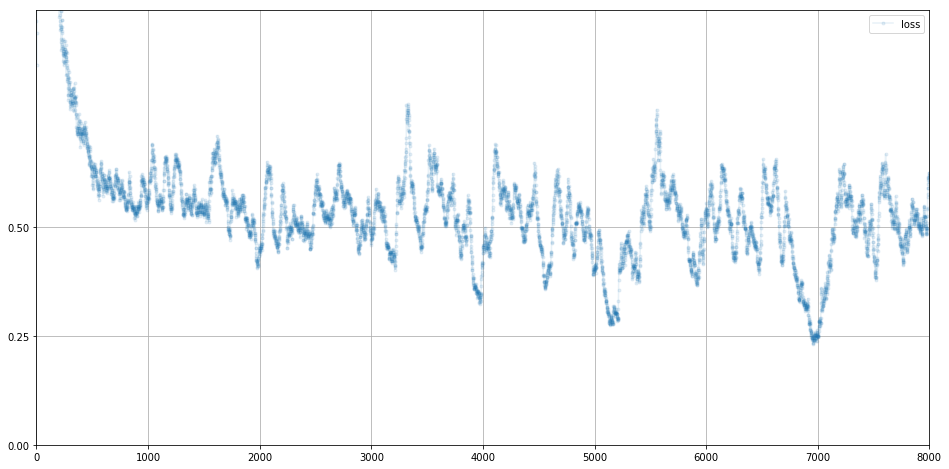

In [96]:
# plot discriminator error

D.plot_progress()

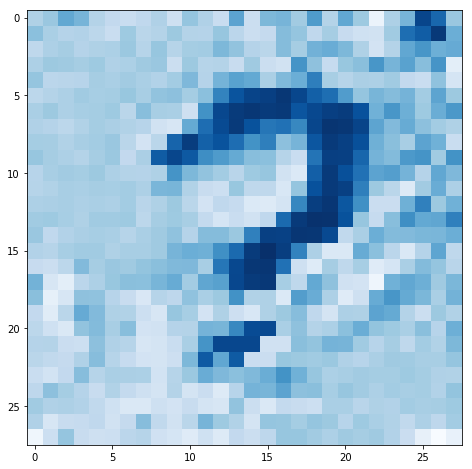

In [98]:
# show generator outputs as they evolve

G.plot_images()

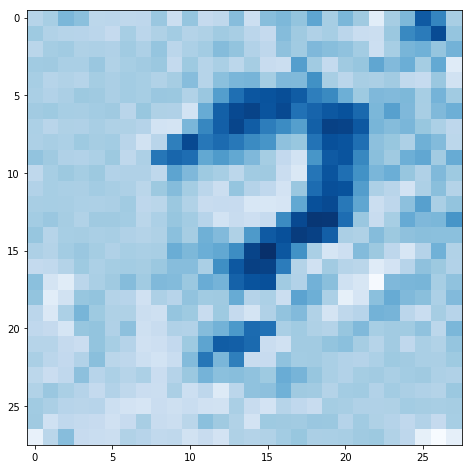

In [99]:
## expts

seed = torch.zeros(100)
seed[random.randint(0,99)] = 1
#seed[0] = 1

plt.figure(figsize = (16,8))
plt.imshow(G.forward(seed.view(1,1,10,10)).view(28,28).detach().cpu().numpy(), 
           interpolation='none',
           cmap='Blues')